In [1]:
import pandas as pd
# from deeplabcut.generate_training_dataset.trainingsetmanipulation import merge_annotateddatasets
# from deeplabcut import auxiliaryfunctions
from wbfm.utils.projects.utils_project import safe_cd, load_config
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pickle
%load_ext autoreload
%autoreload 2
import napari
from wbfm.utils.feature_detection.visualization_tracks import *
from wbfm.utils.pipeline.tracklet_pipeline import partial_track_video_using_config

from wbfm.utils.feature_detection.utils_features import detect_features
from wbfm.utils.external.utils_cv2 import get_keypoints_from_3dseg
from wbfm.utils.feature_detection.utils_features import convert_to_grayscale

In [70]:
project_fname = r'Y:\shared_projects\wbfm\dlc_stacks\Charlie-test-2021_04_26\project_config.yaml'
project_cfg = load_config(project_fname)
segment_fname = project_cfg['subfolder_configs']['segmentation']
segment_fname = project_cfg['subfolder_configs']['training_data']
project_dir = Path(project_fname).parent
with safe_cd(project_dir):
    segment_cfg = load_config(segment_fname)
    training_cfg = load_config(segment_fname)

this_config = segment_cfg.copy()
this_config['dataset_params'] = project_cfg['dataset_params'].copy()

In [71]:
project_fname = r'Y:\shared_projects\wbfm\dlc_stacks\Charlie-immobilized-2021_05_11\project_config.yaml'
cfg = load_config(project_fname)
project_dir = Path(project_fname).parent

base = os.path.join(project_dir, '2-training_data', 'raw')
df = pd.read_pickle(os.path.join(base, 'clust_df_dat.pickle'))
with open(os.path.join(base, 'frame_dat.pickle'), 'rb') as f:
    frame_dat = pickle.load(f)
with open(os.path.join(base, 'match_dat.pickle'), 'rb') as f:
    match_objects = pickle.load(f)
# with open(os.path.join(base, 'candidate_matches_dat.pickle'), 'rb') as f:
#     candidates = pickle.load(f)

# Build an encoder: neurons as keypoints

In [4]:
from tqdm.auto import tqdm

In [5]:
# Get neurons (keypoints)
n0 = frame_dat[0].neuron_locs
im0 = frame_dat[0].get_data()
n1 = frame_dat[1].neuron_locs
im1 = frame_dat[1].get_data()

In [50]:
# n0

In [6]:
# Function for features
def get_encoding_single_slice(kps_xy, im_2d, encoder):
    kps, ds = encoder.compute(im_2d, kps_xy)
    
    return kps, ds
    

def get_all_neuron_encodings(locs_zxy, im_3d):
    im_3d_gray = [convert_to_grayscale(xy) for xy in im_3d]
    # Init
    all_kps = []
    all_des = []    
    z_depth = 2
#     encoder = cv2.ORB_create(1000)
#     encoder.setFastThreshold(0)
    encoder = cv2.xfeatures2d.VGG_create()
    
    # Loop per neuron
    for loc in locs_zxy:
        z, x, y = loc
        kp = cv2.KeyPoint(x, y, 31.0)
        
        z = int(z)
        all_slices = np.arange(z-z_depth, z+z_depth+1)
        all_slices = np.clip(all_slices, 0, len(im_3d_gray))
        # Generate features on neighboring z slices as well
        # Repeat slices if near the edge
        ds = []
        for i in all_slices:
            im_2d = im_3d_gray[int(z)]
            kps, this_ds = get_encoding_single_slice([kp], im_2d, encoder)
            if len(kps)==0:
                print(f"couldn't encode location {loc}")
                raise ValueError
            ds.append(this_ds)
        ds = np.hstack(ds)
            
        all_kps.extend(kps)
        all_des.extend(ds)
        
    return all_kps, all_des

In [23]:
# im_3d_gray = [convert_to_grayscale(xy) for xy in im0]

In [8]:
# Build encoding
kp0, d0 = get_all_neuron_encodings(n0, im0)
kp1, d1 = get_all_neuron_encodings(n1, im1)

In [9]:
# plt.plot([len(d) for d in d0])

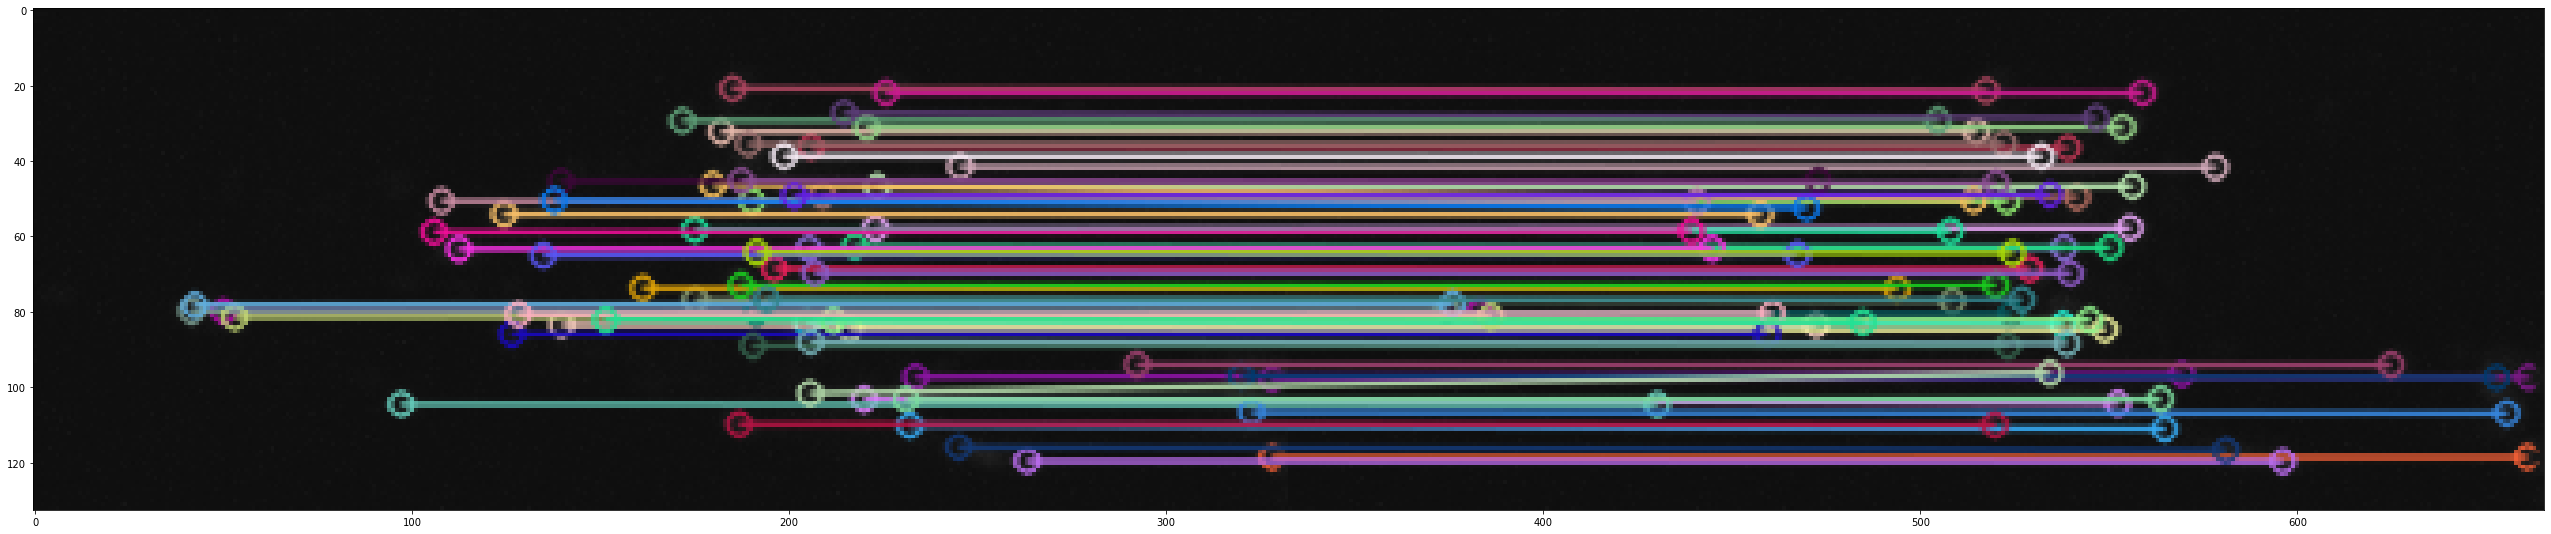

(<matplotlib.image.AxesImage at 0x23e9ab15108>, None)

In [10]:
# Match
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
d0_arr = np.array([d for d in d0])
d1_arr = np.array([d for d in d1])
matches = bf.match(d0_arr,d1_arr)

sz = list(im0.shape)
sz[2] *= 2
out_img = np.zeros((sz[1],sz[2], 3), dtype=np.uint8)

im0_2d = convert_to_grayscale(np.max(im0,axis=0))
im1_2d = convert_to_grayscale(np.max(im1,axis=0))

kp0_arr = list(kp0)
kp1_arr = list(kp1)

img3 = cv2.drawMatches(im0_2d,kp0_arr,im1_2d,kp1_arr,matches, out_img, flags=2)

%matplotlib inline
plt.figure(figsize=(45,15))
plt.imshow(img3),plt.show()

In [11]:

# opt = {'keypoints1': kp0,
#        'keypoints2': kp1,
#        'matches1to2': matches,
#        'withRotation': False,
#        'thresholdFactor': 6.0}
# matches2 = cv2.xfeatures2d.matchGMS(im0.shape[1:], im1.shape[1:], **opt)

In [12]:
matches_arr = [[m.queryIdx, m.trainIdx] for m in matches]
matches_arr

[[0, 1],
 [1, 0],
 [2, 15],
 [3, 6],
 [4, 8],
 [5, 9],
 [6, 7],
 [7, 3],
 [8, 5],
 [9, 4],
 [10, 2],
 [12, 11],
 [13, 14],
 [14, 13],
 [15, 16],
 [17, 20],
 [18, 18],
 [19, 10],
 [20, 17],
 [21, 21],
 [22, 19],
 [23, 22],
 [24, 25],
 [25, 26],
 [26, 28],
 [27, 29],
 [28, 30],
 [29, 32],
 [30, 12],
 [32, 33],
 [33, 27],
 [34, 34],
 [35, 37],
 [36, 39],
 [37, 38],
 [38, 36],
 [39, 40],
 [40, 43],
 [41, 41],
 [43, 42],
 [44, 51],
 [45, 46],
 [46, 45],
 [47, 31],
 [48, 47],
 [49, 44],
 [50, 48],
 [51, 49],
 [52, 50],
 [53, 57],
 [54, 53],
 [55, 55],
 [56, 56],
 [57, 52],
 [58, 64],
 [59, 63],
 [60, 58],
 [61, 59],
 [62, 65],
 [63, 62],
 [64, 61],
 [66, 67]]

In [71]:
matches_arr = [[m.queryIdx, m.trainIdx] for m in matches]
matches_dict = {(0,1): matches_arr}
# plot_matched_point_clouds(frame_dat, matches_dict, (0,1))
visualize_tracks(n0, n1, np.array(matches_arr))

[LineSet with 61 lines.,
 PointCloud with 67 points.,
 PointCloud with 68 points.]

# Use unified function

In [41]:

from wbfm.utils.video_and_data_conversion.import_video_as_array import get_single_volume
vid_fname = cfg['red_bigtiff_fname']
from wbfm.utils.preprocessing.utils_tif import PreprocessingSettings
from wbfm.utils.feature_detection.utils_reference_frames import build_reference_frame_encoding

In [61]:
import_opt = {'num_slices': 33,
                  'alpha': 1.0,
                  'dtype': 'uint16'}
ref_opt = {'z_depth': 2} # TODO: rename this parameter

frame_ind = 0

# dat = get_single_volume(vid_fname, frame_ind, **import_opt)
dat = frame_dat[0].get_data()
metadata = {'frame_ind': frame_ind,
            'vol_shape': dat.shape,
            'video_fname': vid_fname}

preprocessing_settings = PreprocessingSettings()
preprocessing_settings.alpha = 1.0
external_detections = r'Y:\shared_projects\wbfm\dlc_stacks\Charlie-immobilized-2021_05_11\1-segmentation\metadata_500.pickle'

f = build_reference_frame_encoding(dat,
                                   num_slices=import_opt['num_slices'],
                                   **ref_opt,
                                   metadata=metadata,
                                   preprocessing_settings=preprocessing_settings,
                                   external_detections=external_detections)

In [67]:
np.array(f.all_features).shape

(67, 600)

# Test new tracklet function

In [68]:
from wbfm.utils.feature_detection.utils_tracklets import build_tracklets_dfs

In [80]:
# frame_dat[0].neuron_locs

In [82]:
all_matches = [m.final_matches for m in match_objects.values()]
all_xyz = [f.neuron_locs for f in frame_dat.values()]

In [95]:
df = build_tracklets_dfs(all_matches, all_xyz)

In [97]:
# df

# Scratch:  Try my own matcher

In [169]:
from wbfm.utils.feature_detection.utils_networkx import calc_bipartite_from_distance

d0_arr = np.array([d for d in d0.values()])
d1_arr = np.array([d for d in d1.values()])

matches, conf, _ = calc_bipartite_from_distance(d0_arr, d1_arr)

In [180]:
conf

array([[0.50114255],
       [0.50138831],
       [0.50336972],
       [0.50051909],
       [0.50074287],
       [0.50100115],
       [0.50086274],
       [0.50247523],
       [0.50046894],
       [0.50072724],
       [0.5008491 ],
       [0.50112179],
       [0.50071847],
       [0.50103974],
       [0.50103843],
       [0.50417179],
       [0.50087895],
       [0.50103658],
       [0.50133067],
       [0.50089831],
       [0.50178325],
       [0.50067126],
       [0.50085805],
       [0.50141643],
       [0.50085415],
       [0.50285828],
       [0.50188669],
       [0.50081285],
       [0.50092214],
       [0.50128436],
       [0.50055802],
       [0.50140734],
       [0.50086301],
       [0.50087382],
       [0.5023148 ],
       [0.50079411],
       [0.50091052],
       [0.50124441],
       [0.5012766 ],
       [0.50057214],
       [0.50071641],
       [0.50115867],
       [0.50177689],
       [0.5009373 ],
       [0.50155414],
       [0.50070205],
       [0.50105274],
       [0.500

In [176]:
def f(i):
    ind0, ind1 = matches[i]
    zxy0, zxy1 = n0[ind0], n1[ind1]
    
    plt.figure()
    
    plt.subplot(211)
    plt.imshow(np.max(im0, axis=0))
    plt.plot(zxy0[1], zxy0[2], 'ro')
    
    plt.subplot(212)
    plt.imshow(np.max(im1, axis=0))
    plt.plot(zxy1[1], zxy1[2], 'ro')
    
from ipywidgets import interact
interact(f, i=(0,33))

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

<function __main__.f(i)>

### Compare to previous matches